<a href="https://colab.research.google.com/github/yashasvi0403/Datascience-project/blob/main/Internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Section 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense

from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings('ignore')


In [ ]:

# Section 2: Load Dataset
file_path = '/content/dataset.csv'  # Update path if needed
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
# Section 3: Data Preprocessing & Cleaning (Fixed)
df.dropna(how='all', inplace=True)
df.drop_duplicates(inplace=True)

# Fix: Robust datetime parsing
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed', errors='coerce')

# Drop rows where InvoiceDate couldn't be parsed
df = df.dropna(subset=['InvoiceDate'])

# Create TotalPrice and filter for positive values
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df = df[df['TotalPrice'] > 0]
df = df[df['Quantity'] > 0]


In [ ]:

# Section 4: Feature Engineering
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)
rfm['RFM_Score'] = rfm[['RecencyScore','FrequencyScore','MonetaryScore']].sum(axis=1)
rfm.head()


,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,6
12347.0,2,182,4310.00,4,4,4,12
12348.0,75,31,1797.24,2,2,4,8
12349.0,19,73,1757.55,3,3,4,10
12350.0,310,17,334.40,1,1,2,4


In [ ]:

# Section 5: Customer Segmentation using GMM and Agglomerative Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# GMM
gmm = GaussianMixture(n_components=4, random_state=42)
rfm['GMM_Segment'] = gmm.fit_predict(rfm_scaled)

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=4)
rfm['Agg_Segment'] = agg.fit_predict(rfm_scaled)
rfm.head()


,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,GMM_Segment,Agg_Segment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,1,0
12347.0,2,182,4310.00,4,4,4,12,0,0
12348.0,75,31,1797.24,2,2,4,8,0,0
12349.0,19,73,1757.55,3,3,4,10,0,0
12350.0,310,17,334.40,1,1,2,4,2,2


DEBUG:cmdstanpy:input tempfile: /tmp/tmphzds0y8j/ec_7zdpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphzds0y8j/oiza8k2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96751', 'data', 'file=/tmp/tmphzds0y8j/ec_7zdpu.json', 'init=/tmp/tmphzds0y8j/oiza8k2t.json', 'output', 'file=/tmp/tmphzds0y8j/prophet_modelqf2aot9o/prophet_model-20250618114152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:41:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:41:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


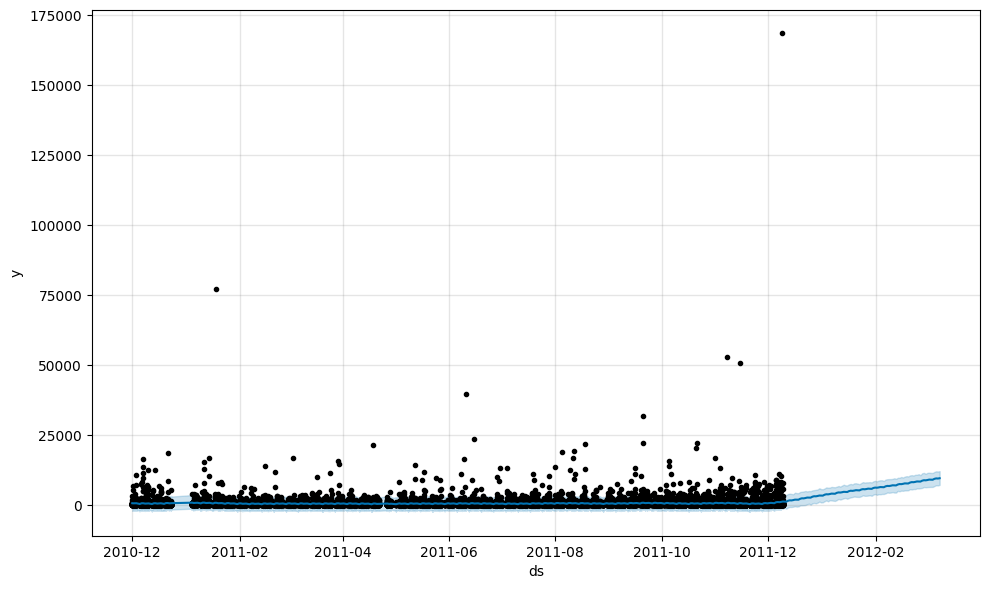

In [ ]:

# Section 6: Sales Forecasting using Prophet
sales = df.groupby('InvoiceDate')['TotalPrice'].sum().reset_index()
sales.columns = ['ds', 'y']

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(sales)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)
fig = model.plot(forecast)


In [ ]:

# Section 7: Churn Prediction Model
df['ChurnFlag'] = df['CustomerID'].duplicated(keep='last').astype(int)
customer_features = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (x.max() - x.min()).days,
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'InvoiceNo': 'count'
}).rename(columns={'InvoiceDate': 'Duration', 'Quantity': 'TotalQty', 'TotalPrice': 'TotalSpend', 'InvoiceNo': 'NumOrders'})

customer_features['ChurnFlag'] = df.groupby('CustomerID')['ChurnFlag'].max()
X = customer_features.drop(columns='ChurnFlag')
y = customer_features['ChurnFlag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[  8   0]
 [  0 860]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00       860

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



In [ ]:

# Imports
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load dataset (ensure 'dataset.csv' is uploaded to the working directory)
df = pd.read_csv('/content/dataset.csv', encoding='ISO-8859-1', low_memory=False)

# Data Cleaning
df.dropna(how='all', inplace=True)
df.drop_duplicates(inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df = df[(df['TotalPrice'] > 0) & (df['Quantity'] > 0)]

# Market Basket Analysis
basket = df[df['Country'] == "United Kingdom"].pivot_table(
    index='InvoiceNo',
    columns='Description',
    values='Quantity',
    aggfunc='sum'
).fillna(0)

# Convert to Boolean
basket = basket > 0

# Apply Apriori Algorithm
frequent_items = apriori(basket, min_support=0.02, use_colnames=True)

# Generate Rules
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

# Display Top Rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


<ipython-input-3-2669062308>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


,antecedents,consequents,support,confidence,lift
0,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.023187,0.548780,8.912517
1,(PACK OF 72 RETROSPOT CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.023187,0.376569,8.912517
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.032462,0.646154,12.116165
3,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.032462,0.608696,12.116165
4,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE IVORY),0.020611,0.386473,12.931867
